## Introduction

This notebook uses historical futures data of 25 different commodities and analyzes portfolio allocations based on four factors/anomalies present in the commodity market:

1. momentum
2. basis/term-structure
3. idiosyncratic volatility
4. skewness

I analyze portfolio sorts based on each single signal and combined signals. I also compare properties of the cross-sectional and time-series signaling. The results can be used to diversify a conventional portfolio of stocks (and bonds) as commodity factors are uncorrelated to common equity factors.

**Sample Description**
* 25 commodities
* Sample spans from 1980 to 2022
* Price data is retrieved from Thomson Reuters Datastream and the Chicago Mercantile Exchange (CME)

**References**
* Miffre, J., & Rallis, G. (2007). Momentum strategies in commodity futures markets. Journal of Banking & Finance, 31(6), 1863-1886.
https://risk.edhec.edu/sites/risk/files/pdf/RISKArticle.2007-11-16.4731/attachments/Momentum%20Strategies%20Commodity%20Futures.pdf
* Fuertes, A. M., Miffre, J., & Fernandez‐Perez, A. (2015). Commodity strategies based on momentum, term structure, and idiosyncratic volatility. Journal of Futures Markets, 35(3), 274-297.
https://risk.edhec.edu/sites/risk/files/edhec-working-paper-commodity-strategies-based-on-momentum_1368521019664_0.pdf
* Fuertes, A. M., Miffre, J., & Rallis, G. (2010). Tactical allocation in commodity futures markets: Combining momentum and term structure signals. Journal of Banking & Finance, 34(10), 2530-2548.
https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.458.5618&rep=rep1&type=pdf
* Miffre, J. (2016). Long-short commodity investing: A review of the literature. Journal of Commodity Markets, 1(1), 3-13.
https://risk.edhec.edu/sites/risk/files/edhec_working_paper_long-short_commodity_investing.pdf
* Fernandez-Perez, A., Frijns, B., Fuertes, A. M., & Miffre, J. (2018). The skewness of commodity futures returns. Journal of Banking & Finance, 86, 143-158.
https://openaccess.city.ac.uk/id/eprint/17843/1/SSRN-id2671165_July2017.pdf
* Gorton, G. B., Hayashi, F., & Rouwenhorst, K. G. (2013). The fundamentals of commodity futures returns. Review of Finance, 17(1), 35-105.
https://www.nber.org/system/files/working_papers/w13249/w13249.pdf

#### Library import and setting up the data

In [1]:
from finance_database import Database
from finance_data import YahooReader
import datetime as dt
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
db = Database()
con = db.connection
cur = db.cursor

In [3]:
commodities = cur.execute("SELECT name FROM commodities").fetchall()
commodities = [item[0] for item in commodities]
commodities

['Aluminum',
 'Cocoa',
 'Coffee',
 'Copper',
 'Corn',
 'Cotton',
 'Feeder Cattle',
 'Gold',
 'Heating Oil',
 'Lead',
 'Lean Hogs',
 'Live Cattle',
 'Milk',
 'Natural Gas',
 'Oats',
 'Palladium',
 'Platinum',
 'Silver',
 'Soybean',
 'Soybean Meal',
 'Soybean Oil',
 'Sugar',
 'WTI Crude Oil',
 'Wheat',
 'Zinc']

#### Query the raw futures prices

In [4]:
futures = {}
for index, commodity in enumerate(commodities):
    id_ = cur.execute("SELECT id FROM commodities WHERE name = ?", (commodity,)).fetchall()[0][0]
    print(f"{index+1} of {len(commodities)}: {commodity}")
    data = cur.execute("SELECT ts, maturity_date, price FROM commodity_prices WHERE commodity_id = ?", (id_,)).fetchall()
    futures[commodity] = pd.DataFrame()
    for item in data:
        date, maturity, price = item
        futures[commodity].loc[pd.to_datetime(date, unit="s"), pd.to_datetime(maturity, unit="s")] = price
    futures[commodity].sort_index(inplace=True)
    futures[commodity] = futures[commodity].resample("m").last()
    futures[commodity].index = [pd.to_datetime(f"{index.year}-{index.month}-01") for index in futures[commodity].index]

1 of 25: Aluminum
2 of 25: Cocoa
3 of 25: Coffee
4 of 25: Copper
5 of 25: Corn
6 of 25: Cotton
7 of 25: Feeder Cattle
8 of 25: Gold
9 of 25: Heating Oil
10 of 25: Lead
11 of 25: Lean Hogs
12 of 25: Live Cattle
13 of 25: Milk
14 of 25: Natural Gas


C:\Users\Jonas\AppData\Local\Temp\ipykernel_325884\1420574791.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  futures[commodity].loc[pd.to_datetime(date, unit="s"), pd.to_datetime(maturity, unit="s")] = price


15 of 25: Oats
16 of 25: Palladium
17 of 25: Platinum
18 of 25: Silver
19 of 25: Soybean


C:\Users\Jonas\AppData\Local\Temp\ipykernel_325884\1420574791.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  futures[commodity].loc[pd.to_datetime(date, unit="s"), pd.to_datetime(maturity, unit="s")] = price


20 of 25: Soybean Meal
21 of 25: Soybean Oil
22 of 25: Sugar
23 of 25: WTI Crude Oil


C:\Users\Jonas\AppData\Local\Temp\ipykernel_325884\1420574791.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  futures[commodity].loc[pd.to_datetime(date, unit="s"), pd.to_datetime(maturity, unit="s")] = price


24 of 25: Wheat
25 of 25: Zinc


#### Find the front month and compute continuous (including rollover) returns

In [5]:
contracts = pd.DataFrame()
continuous_returns = pd.DataFrame()
for index, commodity in enumerate(commodities):
    print(f"{index+1} of {len(commodities)}: {commodity}")
    for index in futures[commodity].index:
        for col in futures[commodity].columns:
            if col > index + relativedelta(months=1):
                contracts.loc[index, commodity] = col
                break
    for i, index in enumerate(futures[commodity].index):
        contract_month = contracts.loc[index, commodity]
        continuous_returns.loc[index, commodity] = futures[commodity].loc[futures[commodity].index[i], contract_month] / futures[commodity].loc[futures[commodity].index[i-1], contract_month] - 1
contracts.sort_index(inplace=True)
continuous_returns.sort_index(inplace=True)

1 of 25: Aluminum
2 of 25: Cocoa
3 of 25: Coffee
4 of 25: Copper
5 of 25: Corn
6 of 25: Cotton
7 of 25: Feeder Cattle
8 of 25: Gold
9 of 25: Heating Oil
10 of 25: Lead
11 of 25: Lean Hogs
12 of 25: Live Cattle
13 of 25: Milk
14 of 25: Natural Gas
15 of 25: Oats
16 of 25: Palladium
17 of 25: Platinum
18 of 25: Silver
19 of 25: Soybean
20 of 25: Soybean Meal
21 of 25: Soybean Oil
22 of 25: Sugar
23 of 25: WTI Crude Oil
24 of 25: Wheat
25 of 25: Zinc


To ensure the data quality and that I haven't done anything wrong, let's compare the hypothetical performance with those achieved with tradable ETC's on the respective commodity:

In [6]:
commodity_etc_match = {
    "Cocoa": "COCO.L",
    "Coffee": "COFF.L",
    "Copper": "COPA.L",
    "Corn": "CORN.L",
    "Cotton": "COTN.L",
    "Gold": "GLD",
    "Heating Oil": "HEAT.L",
    "Lead": "LEED.L",
    "Lean Hogs": "HOGS.L",
    "Live Cattle": "CATL.L",
    "Natural Gas": "UNG",
    "Silver": "SLV",
    "Soybean": "SOYB.L",
    "Soybean Oil": "SOYO.L",
    "Sugar": "SUGA.L",
    "WTI Crude Oil": "USO",
    "Wheat": "WEAT.L",
    "Zinc": "ZINC.L"
}

Cocoa


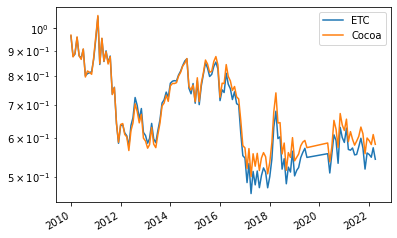

Coffee


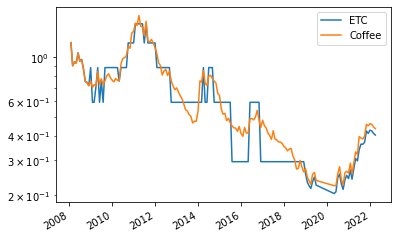

Copper


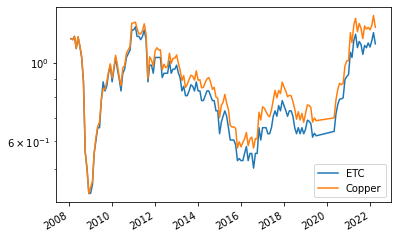

Corn


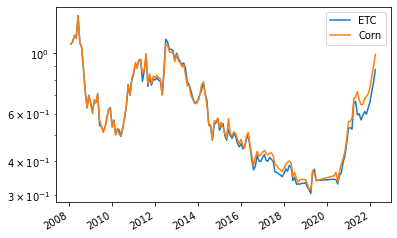

Cotton


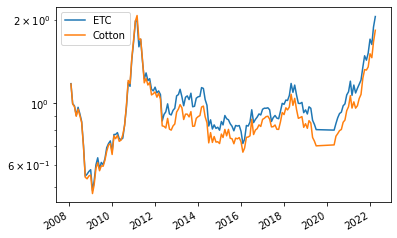

Gold


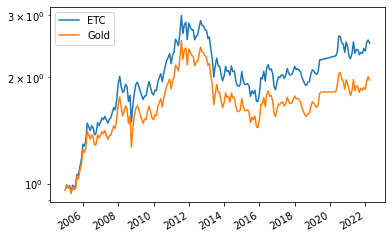

Heating Oil


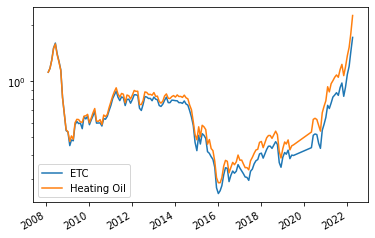

Lead


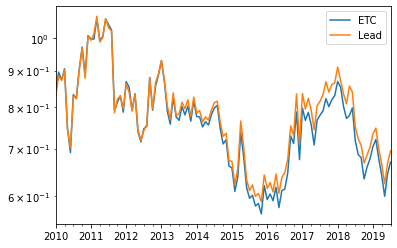

Lean Hogs


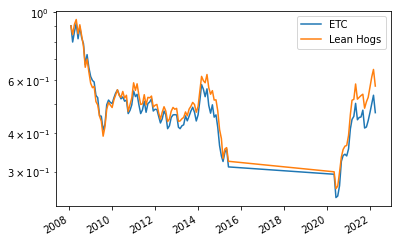

Live Cattle


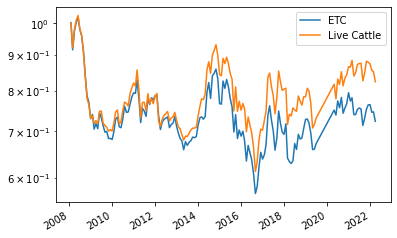

Natural Gas


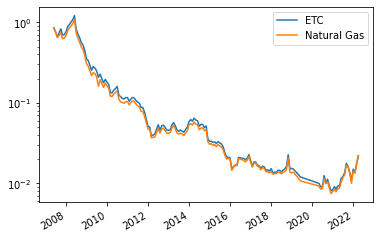

Silver


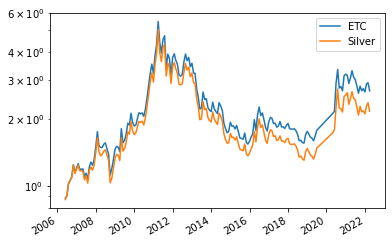

Soybean


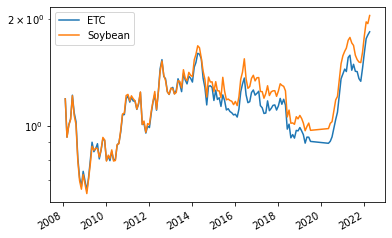

Soybean Oil


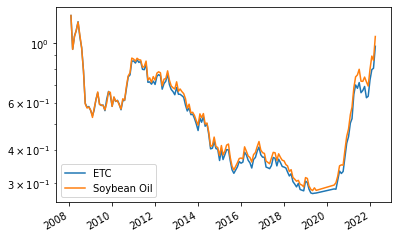

Sugar


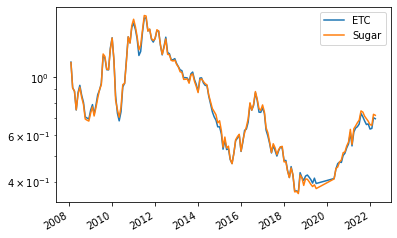

WTI Crude Oil


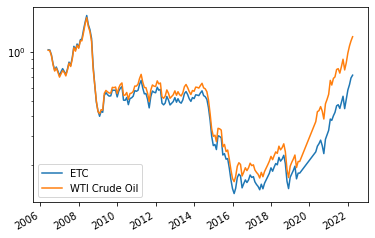

Wheat


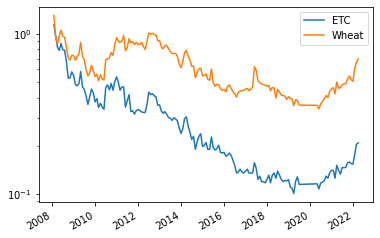

Zinc


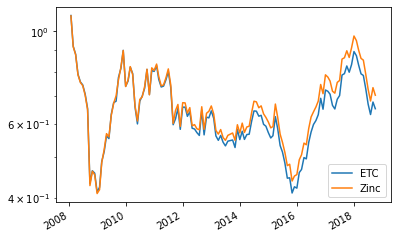

In [7]:
for commodity in commodity_etc_match:
    print(commodity)
    etc = commodity_etc_match[commodity]
    etc = YahooReader(etc).historical_data(frequency="1mo")["data"]["simple_returns"]
    etc.name = "ETC"
    merged_df = pd.concat([etc, continuous_returns[commodity].replace(0, np.NaN)], axis=1).dropna()
    (1+merged_df).cumprod().plot()
    plt.yscale("log")
    plt.show()
    print("===========================================")

Except for wheat and some minor data quality issues, the resulting performances are very similar. For the analysis, I therefore cut wheat out of the sample:

In [415]:
commodities.remove("Wheat")

ValueError: list.remove(x): x not in list

In [416]:
returns_12_2 = pd.DataFrame()
for commodity in commodities:
    returns_12_2[commodity] = (1+continuous_returns[commodity]).cumprod().shift(1) / (1+continuous_returns[commodity]).cumprod().shift(12)- 1